# Analysis of Meerkat Call Sequences 

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH

### Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [3]:
import os
import pandas as pd
import sys
from IPython.display import Audio 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import glob
from pandas.core.common import flatten
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime
from scipy.stats import zscore
os.system('pip install umap-learn')
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import scipy
import math
import random
from random import sample
from scipy import stats
from datetime import time
from datetime import datetime

In [4]:
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

distinct_colors_20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                       '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                       '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                       '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                       '#ffffff', '#000000']  

distinct_colors_13 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                      '#911eb4', '#46f0f0', '#f032e6', #'#fffac8', 
                      '#008080', '#e6beff', '#9a6324', '#000000', '#aaffc3']

### Functions

In [5]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

#### Visualization

In [7]:
def mara_3Dplot(x,y,z,scat_labels, mycolors,outname):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')

  labeltypes = sorted(list(set(scat_labels)))
  customPalette = sns.color_palette(mycolors, n_colors=len(labeltypes))

  color_dict = dict(zip(labeltypes, customPalette))
  c = [color_dict[val] for val in scat_labels]

  Axes3D.scatter(ax,
                xs = x,
                ys = y,
                zs = z,
                zdir='z',
                s=20,
                label = c,
                c=c,
                depthshade=False)

  ax.set_xlabel('UMAP1')
  ax.set_ylabel('UMAP2')
  ax.set_zlabel('UMAP3')

  scatters = []
  for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

  ax.legend(scatters, labeltypes, numpoints = 1)

  #plt.show()
  plt.savefig(FIGURES+outname)



def plotly_viz(x,y,z,scat_labels, mycolors):

  labeltypes = sorted(list(set(scat_labels)))


  pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
  color_dict = dict(zip(labeltypes, pal))
  c = [color_dict[val] for val in scat_labels]

  fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = scat_labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

  fig.update_layout(scene = dict(
                      xaxis_title='UMAP1',
                      yaxis_title='UMAP2',
                      zaxis_title='UMAP3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

  return fig

#plotly_viz(df['UMAP1'], df['UMAP2'], df['UMAP3'],df.cc_seq, "Set2")

# UMAP projection

In [8]:
df = pd.read_pickle(DATA+'df_denoised') # full

In [9]:
df

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,nonfocal_yn
1584,CC,1:00:15.043,0:00.083,decimal,Cue,NaN,y,3615.043,0.083,3615.126,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,4,cc,"[-0.0078125, 0.00390625, -0.009765625, -0.0058...","[[-5.00301, -5.2624416, -4.9811325, -4.3282547...","[[-147.81346, -151.1712, -158.07703, -159.4540...","[[0.71534294, 0.71534294, 0.71534294, 0.715342...","[[0.20987451, 0.20987451, 0.20987451, 0.209874...",n,"[[-10.160519, -8.448254, -8.041008, -9.920231,...","[[-299.12057, -277.68695, -226.69044, -194.237...","[[12.585518, 12.585518, 12.585518, 12.585518, ...","[[-8.019515, -8.019515, -8.019515, -8.019515, ...","[[17.339697, 18.042007, 19.765783, 22.686983, ...","[[38.11735, 37.514843, 31.096657, 21.984482, 1...","[[-6.505764, -3.7809324, -1.5637956, 11.405321...","[[6.215486, 13.009188, 20.837872, 7.5455985, -...","[[2.7452314, 2.7452314, 2.7452314, 2.7452314, ...","[[-0.36869705, -0.36869705, -0.36869705, -0.36...",y,n
1585,CC,1:00:35.627,0:00.191,decimal,Cue,NaN,y,3635.627,0.191,3635.818,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,5,cc,"[-0.021484375, -0.01953125, -0.015625, -0.0253...","[[-2.0994568, -2.1183338, -2.4481869, -2.52930...","[[-182.17676, -172.59605, -161.6688, -155.9510...","[[4.782921, 4.782921, 4.782921, 4.782921, 4.78...","[[-0.14873402, -0.14873402, -0.14873402, -0.14...",n,"[[-3.6559372, -4.0523834, -3.5657997, -3.85589...","[[-283.74167, -262.43655, -224.60722, -199.279...","[[10.116256, 10.116256, 10.116256, 10.116256, ...","[[-6.1125464, -6.1125464, -6.1125464, -6.11254...","[[26.603214, 23.59336, 22.140139, 22.74288, 25...","[[39.65626, 34.43138, 31.346516, 26.531246, 24...","[[-0.6451429, -9.981032, -6.158573, 3.8842514,...","[[-9.811282, -19.043835, -3.8023443, -7.094287...","[[-0.09826555, -0.09826555, -0.09826555, -0.09...","[[0.5400675, 0.5400675, 0.5400675, 0.5400675, ...",y,n
1586,CC,1:01:10.577,0:00.145,decimal,Cue,NaN,y,3670.577,0.145,3670.722,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,8,cc,"[-0.0390625, -0.037109375, -0.041015625, -0.03...","[[-9.536743e-07, -1.0446749, -4.06676, -8.0304...","[[-198.96457, -183.90721, -165.92061, -154.107...","[[6.3840265, 6.3840265, 6.3840265, 6.3840265, ...","[[-3.1363256, -3.1363256, -3.1363256, -3.13632...",n,"[[-8.488825, -6.3999805, -2.294176, 1.9073486e...","[[-289.95355, -267.5201, -246.2507, -229.30716...","[[11.541756, 11.541756, 11.541756, 11.541756, ...","[[-3.604664, -3.604664, -3.604664, -3.604664, ...","[[31.281498, 28.889343, 23.64156, 17.571968, 1...","[[39.643806, 35.62033, 37.063484, 35.356842, 3...","[[-1.1229907, 5.4121504, 9.322178, 7.8163314, ...","[[14.463937, -1.7603488, 2.6689968, -5.6908846...","[[0.36921495, 0.36921495, 0.36921495, 0.369214...","[[-0.6972977, -0.6972977, -0.6972977, -0.69729...",y,n
1587,CC,1:01:14.981,0:00.170,decimal,Cue,NaN,y,3674.981,0.170,3675.151,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,9,cc,"[-0.025390625, 0.00390625, 0.009765625, -0.013...","[[-17.018482, -14.399429, -10.718897, -8.12332...","[[-129.18015, -119.59427, -107.96855, -99.0367...","[[7.9122534, 7.9122534, 7.9122534, 7.9122534, ...","[[-2.6924, -2.6924, -2.6924, -2.6924, -2.6924,...",n,"[[-16.365925, -18.497864, -22.572521, -13.1064...","[[-221.61533, -205.87352, -167.19315, -144.431...","[[10.7703495, 10.7703495, 10.7703495, 10.77034...","[[-5.425819, -5.425819, -5.425819, -5.425819, ...","[[2.7982006, 4.153269, 6.9078026, 8.030533, 5....","[[16.299934, 14.559074, 3.6322708, 9.765892, 1...","[[-3.848446,

In [10]:
cc_df = df[df.call_lable == 'cc']
cc_df.shape

(19356, 34)

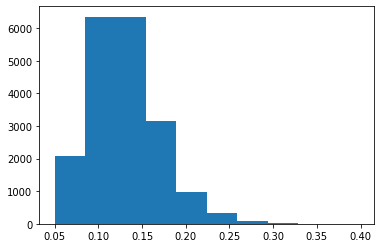

In [11]:
n, bins, patches = plt.hist(cc_df.duration_s)

## Run UMAP

### UMAP with precomputed dist matrix

#### Precompute pairwise-padding distance matrix

In [16]:
import numba
from numba import jit

MEL_BINS_REMOVED_LOWER = 5
MEL_BINS_REMOVED_UPPER = 5
N_MELS = 40

@jit(nopython=True)
def calc_zscore(spec):
    mn = np.mean(spec)
    std = np.std(spec)
    for i in range(spec.shape[0]):
        for j in range(spec.shape[1]):
            spec[i,j] = (spec[i,j]-mn)/std
    return spec

@jit(nopython=True)
def preprocess_spec_numba(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    spec = calc_zscore(spec)
    spec = np.where(spec > 3, 3, spec)
    spec = np.where(spec < 0, 0, spec)
    
    return spec

In [19]:
specs = cc_df.spectrograms
s_list = [preprocess_spec_numba(s) for s in specs]

##### Check time requirements

In [20]:
import timeit

sample_list = random.sample(s_list,30)
time_diffs = []
distmat = np.zeros((len(sample_list), len(sample_list)))

for i in range(len(sample_list)):
  for j in range(i+1,len(sample_list)):
    starttime = timeit.default_timer()
    specs = [sample_list[i], sample_list[j]]
    spec_ls = [s.shape[1] for s in specs]
    longer = np.argmax(spec_ls)
    maxlen = np.max(spec_ls)

    longer_spec = specs[longer]
    shorter_spec = specs[int(not longer)]

    padded_spec = pad_spectro(shorter_spec, maxlen)
    distmat[i,j] = scipy.spatial.distance.euclidean(padded_spec.flatten(), longer_spec.flatten())
    time_diff = timeit.default_timer() - starttime
    time_diffs.append(time_diff)

In [21]:
n_comps = ((len(s_list)**2) - len(s_list)) / 2
print(n_comps, " computations")
s_per_comp = np.mean(time_diffs)
print(round(s_per_comp,5), "s / computation")
print(round((n_comps * s_per_comp),2), "s for dist mat")
print(round((n_comps * s_per_comp)/60/60,2), "h for dist mat")

187317690.0  computations
5e-05 s / computation
9654.22 s for dist mat
2.68 h for dist mat


##### Run for full dataset

In [22]:
distmat = np.zeros((len(s_list), len(s_list)))
for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    specs = [s_list[i], s_list[j]]
    spec_ls = [s.shape[1] for s in specs]
    longer = np.argmax(spec_ls)
    maxlen = np.max(spec_ls)

    longer_spec = specs[longer]
    shorter_spec = specs[int(not longer)]

    padded_spec = pad_spectro(shorter_spec, maxlen)
    distmat[i,j] = scipy.spatial.distance.euclidean(padded_spec.flatten(), longer_spec.flatten())

np.save(PROJECT_PATH+'04_2021_distmat_cc.npy', distmat)

KeyboardInterrupt: ignored

In [ ]:
for i in range(len(s_list)):
  for j in range(i+1,len(s_list)):
    distmat[j,i] = distmat[i,j]
np.save(PROJECT_PATH+'04_2021_distmat_cc.npy', distmat)

#### UMAP

In [ ]:
reducer = umap.UMAP(low_memory=True,n_components = 5, min_dist=0, metric='precomputed')
embedding = reducer.fit_transform(distmat)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



### UMAP without precomputed dist matrix

In [ ]:
specs = cc_df.denoised_spectrograms.values

In [ ]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

data.shape

In [ ]:
reducer = umap.UMAP(low_memory=True, n_components = 5, min_dist=0, random_state=2204)
embedding = reducer.fit_transform(data)
embedding.shape 

(872, 5)

## Save UMAP results



In [ ]:
for i in range(embedding.shape[1]):
  cc_df['UMAP'+str(i+1)] = embedding[:,i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
umap_df.to_pickle(PROJECT_PATH+'cc_umap_df.pkl')

## Visualization

### 3D Plots

#### Matplotlib animation

In [ ]:
#umap_df = pd.read_pickle(PROJECT_PATH+'cc_umap_df.pkl')

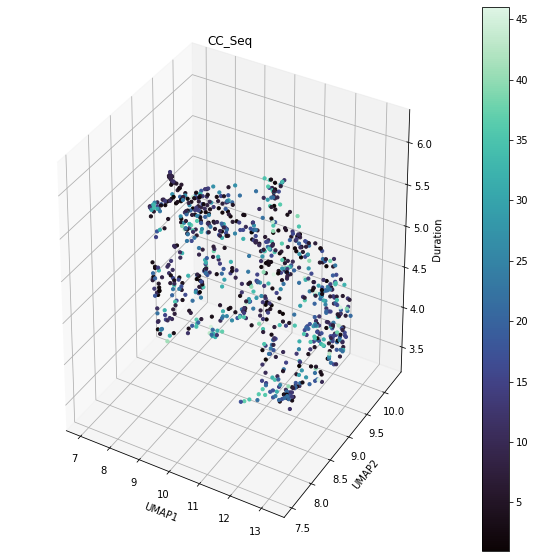

In [ ]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#scat_labels = umap_df.GroupName.values
#scat_labels = umap_df.ID.values
#scat_labels = umap_df.callType.values
scat_labels = umap_df.cc_seq.values
#scat_labels = umap_df.seq.values
labeltypes = list(set(scat_labels))

#pal = sns.color_palette("Set2", n_colors=len(labeltypes))
pal = sns.color_palette(n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

sm = ScalarMappable(norm=Normalize(vmin=min(scat_labels), vmax=max(scat_labels)), cmap=sns.color_palette("mako", as_cmap=True))

mycolor=[sm.to_rgba(x) for x in scat_labels]

ax.set_title("CC_Seq")



Axes3D.scatter(ax,
               xs = umap_df['UMAP1'],
               ys = umap_df['UMAP2'],
               #zs= umap_df['duration'],
               zs= umap_df['UMAP3'],
               zdir='z',
               s=10,
               label = mycolor,
               #c=c,
               c=mycolor,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('Duration')
#ax.set_zlabel('UMAP3')

scatters = []
#for label in labeltypes:
#  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=sm.to_rgba(label), marker = 'o'))

#ax.legend(scatters, labeltypes, numpoints = 1)
plt.colorbar(sm)

plt.show()

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'3D.gif', dpi=80, writer='pillow', fps=12)

# Play animation
# this is the part which makes it work on Colab
#rc('animation', html='jshtml')
#anim

#### Plotly

In [ ]:
#t = np.linspace(0, 10, 50)
x, y, z = umap_df['UMAP1'], umap_df['UMAP2'],  umap_df['UMAP3'] #umap_df['duration']
#scat_labels = umap_df.GroupName.values
scat_labels = umap_df.callType.values

labeltypes = list(set(scat_labels))
# makes colors same as AVGN visualization
pal = sns.color_palette(n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   hovertext = umap_df.callType.values, #+ " (" +umap_df.Name.values+")",
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# Preparation for analysis

## Calculate time diff distance matrix

In [ ]:
# Function that gets datatime object from timestring
# timestring must match one of the given time_patterns
# Input: some string containing a time (String)
# Output: datetime object
# Example usage: dt = get_datetime("2019-07-17 13:59:55.838")

def get_datetime(timestring):
    time_patterns = ['%Y-%m-%d %H:%M:%S.%f', '%Y-%m-%d %H:%M:%S']
    for pattern in time_patterns:
        try:
            return datetime.strptime(timestring, pattern)
        except:
            pass

    print("Date is not in expected format:", timestring)
    
    sys.exit(0)  

def get_timediff(time1, time2):
  duration = time1-time2
  return abs(duration.total_seconds())

In [ ]:
# get datetime:
date_time = [get_datetime(x) for x in cc_df['t0GPS_UTC']]

In [ ]:
time_diff_mat = np.zeros((len(date_time), len(date_time)))

for i in range(len(date_time)):
  print('\rProcessing i:',i, end='')
  for j in np.arange(i,len(date_time)):
    time_diff_mat[i,j] = get_timediff(date_time[i],date_time[j])
    time_diff_mat[j,i] = time_diff_mat[i,j]

np.save(PROJECT_PATH+'time_diff_mat_2021-03-30.npy', time_diff_mat)
#np.save(PROJECT_PATH+'time_diff_mat_2021-01-20.npy', time_diff_mat_c)

Processing i: 13848

## Calculate distance matrix (if not already precomputed)

In [ ]:
specs = cc_df.denoised_spectrograms.values

maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

embedding_df = pd.DataFrame(data)

In [ ]:
distmat = distance_matrix(data, data, p=2) # minkowski norm p=2 -> euclidean
np.save(PROJECT_PATH+'distmat_2021-01-20.npy', distmat)

In [ ]:
distmat.shape

(13848, 13848)

# Analysis

Load dataset and distance matrices

In [ ]:
# A) removed long dur calls, padded all, no preprocessing

distmat = np.load(PROJECT_PATH+'distmat_2021-01-20.npy')
time_diff_mat = np.load('time_diff_mat_2021-01-20.npy')

umap_df = pd.read_pickle(PROJECT_PATH+'all_calls.pkl')
cc_df = umap_df.loc[umap_df['callType']=='cc',:]
cc_df = cc_df.loc[cc_df.duration<0.4,:] # this is actually just one call

print(distmat.shape)
print(time_diff_mat.shape)
print(cc_df.shape)

(13848, 13848)
(13848, 13848)
(13848, 50)


In [ ]:
# B) preprocessed, pairwise padding

distmat = np.load(PROJECT_PATH+'distmat_cc.npy')
time_diff_mat = np.load('time_diff_mat_2021-03-30.npy')

umap_df = pd.read_pickle(PROJECT_PATH+'all_calls.pkl')
cc_df = umap_df.loc[umap_df['callType']=='cc',:]

print(distmat.shape)
print(time_diff_mat.shape)
print(cc_df.shape)

(13849, 13849)
(13849, 13849)
(13849, 50)


Pull some example spectograms to check if the distances make sense:

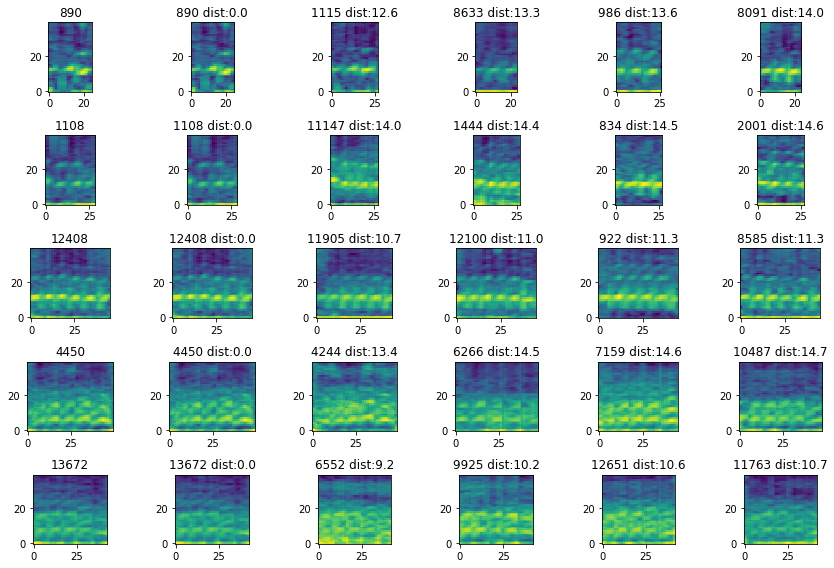

In [ ]:
plt.figure(figsize=(12, 8))
pos=1
random.seed(2204)

for i in range(5):

  # Select a random call

  rn = random.randrange(0, distmat.shape[0])
  spec = cc_df.iloc[rn,:].denoised_spectrograms

  plt.subplot(5, 6, pos)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal')
  plt.title(rn)
  pos = pos+1

  # Find the 5 calls that are matched with smallest distances

  k=5
  distances = distmat[rn,:]
  neighbor_inds = np.argsort(distances)[:k]

  for ind in neighbor_inds:
    spec=cc_df.iloc[ind,:].denoised_spectrograms

    plt.subplot(5, 6, pos)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal')
    plt.title(str(ind)+" dist:"+str(round(distances[ind],1)))
    pos = pos+1

plt.tight_layout()

Altogether, looks alright.

In [ ]:
indvs = sorted(list(set(cc_df.ind)))

In [ ]:
indv = indvs[5]
rns = [cc_df.index.get_loc(x) for x in cc_df.index[cc_df.ind==indv]]

sub_distmat = distmat[rns,:]
sub_distmat = sub_distmat[:,rns]

sub_time_distmat = time_diff_mat[rns,:]
sub_time_distmat = sub_time_distmat[:,rns]

In [ ]:
# Use only upper half of matrix
all_dists = []

for i in range(sub_distmat.shape[0]):
  all_dists.append(sub_distmat[i,0:i])
all_dists_vec = np.hstack(all_dists).flatten()

# Use only upper half of matrix
all_time_diffs = []

for i in range(sub_time_distmat.shape[0]):
  all_time_diffs.append(sub_time_distmat[i,0:i])
all_time_diffs_vec = np.hstack(all_time_diffs).flatten()

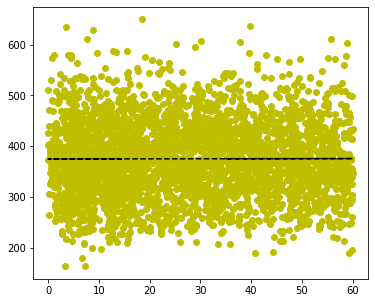

In [ ]:
x = all_time_diffs_vec[all_time_diffs_vec<=60]
y = all_dists_vec[all_time_diffs_vec<=60]

#x = all_time_diffs_vec
#y = all_dists_vec

fig = plt.figure(figsize=(6, 5))
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
#plt.plot(x, y, 'o', color='black')

In [ ]:
import datetime

In [ ]:
pal = sns.color_palette(distinct_colors_20, n_colors=len(indvs))
color_dict = dict(zip(indvs, pal))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



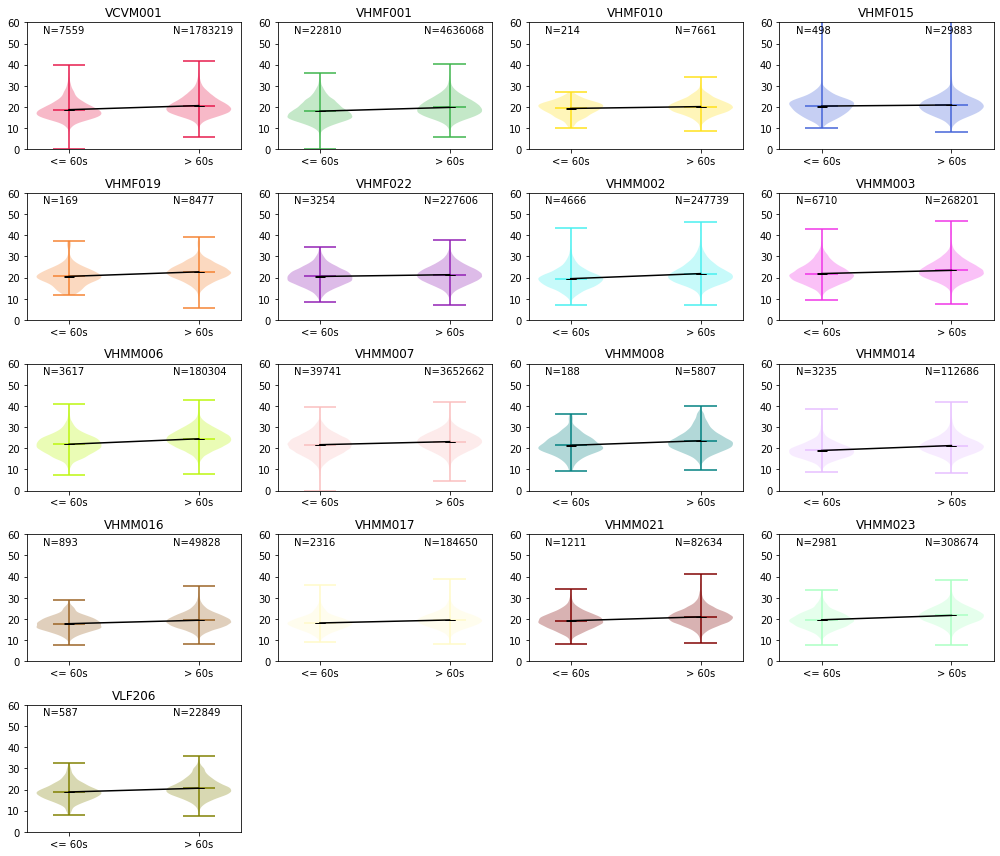

In [ ]:
cutoff_s = 60

fig = plt.figure(figsize=(14, 12))
pos=1

for ind in indvs:
  rns = [cc_df.index.get_loc(x) for x in cc_df.index[cc_df.ind==ind]]

  sub_distmat = distmat[rns,:]
  sub_distmat = sub_distmat[:,rns]

  sub_time_distmat = time_diff_mat[rns,:]
  sub_time_distmat = sub_time_distmat[:,rns]

  # Use only lower half of matrix, discard diagonal
  all_dists = []
  
  for i in range(sub_distmat.shape[0]):
    all_dists.append(sub_distmat[i,0:i])
  all_dists_vec = np.hstack(all_dists).flatten()

  # Use only lower half of matrix, discard original
  all_time_diffs = []

  for i in range(sub_time_distmat.shape[0]):
    all_time_diffs.append(sub_time_distmat[i,0:i])
  all_time_diffs_vec = np.hstack(all_time_diffs).flatten()

  #x = all_time_diffs_vec[all_time_diffs_vec<=60*10]
  #y = all_dists_vec[all_time_diffs_vec<=60*10]

  bin_types = {
    0 : list(all_time_diffs_vec[all_time_diffs_vec<=cutoff_s]),
    1 : list(all_time_diffs_vec[all_time_diffs_vec>cutoff_s]),
    }
    
  # make dictionary labels to calls
  times_to_bins = dict((v,k) for k in bin_types for v in bin_types[k])

  x = [times_to_bins[x] for x in all_time_diffs_vec]
  #y = all_dists_vec
  
  plt.subplot(5, 4, pos)  
  #sns.regplot(x,y,scatter=False).set_title(ind)


  within_dists = all_dists_vec[np.asarray(x)==0]
  outside_dists = all_dists_vec[np.asarray(x)==1]

  bp = plt.violinplot([within_dists, outside_dists],
                      showmeans=True)
  #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])
      
  #plt.text(0.8,660, "N="+str(len(within_dists)))
  #plt.text(1.8,660, "N="+str(len(outside_dists)))

  plt.text(0.8,55, "N="+str(len(within_dists)))
  plt.text(1.8,55, "N="+str(len(outside_dists)))

  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[ind])

  for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[ind])

  plt.errorbar([1,2],
              [np.mean(within_dists), np.mean(outside_dists)], 
              yerr = [stats.sem(within_dists), stats.sem(outside_dists)],
              capsize=5, color = 'black')

  plt.xticks([1,2],['<= '+str(cutoff_s)+'s',
                    '> '+str(cutoff_s)+'s'])
  plt.title(ind)
  #plt.ylim(175,700)
  plt.ylim(0,60)
  pos = pos+1

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'violin_all_ccs_'+str(cutoff_s)+'s.png')

In [ ]:
cutoff_s = 60

fig = plt.figure(figsize=(14, 12))
pos=1

ind = indvs[0]

  rns = [cc_df.index.get_loc(x) for x in cc_df.index[cc_df.ind==ind]]

  sub_distmat = distmat[rns,:]
  sub_distmat = sub_distmat[:,rns]

  sub_time_distmat = time_diff_mat[rns,:]
  sub_time_distmat = sub_time_distmat[:,rns]

  # Use only lower half of matrix, discard diagonal
  all_dists = []
  
  for i in range(sub_distmat.shape[0]):
    all_dists.append(sub_distmat[i,0:i])
  all_dists_vec = np.hstack(all_dists).flatten()

  # Use only lower half of matrix, discard original
  all_time_diffs = []

  for i in range(sub_time_distmat.shape[0]):
    all_time_diffs.append(sub_time_distmat[i,0:i])
  all_time_diffs_vec = np.hstack(all_time_diffs).flatten()

  #x = all_time_diffs_vec[all_time_diffs_vec<=60*10]
  #y = all_dists_vec[all_time_diffs_vec<=60*10]

  bin_types = {
    0 : list(all_time_diffs_vec[all_time_diffs_vec<=cutoff_s]),
    1 : list(all_time_diffs_vec[all_time_diffs_vec>cutoff_s]),
    }
    
  # make dictionary labels to calls
  times_to_bins = dict((v,k) for k in bin_types for v in bin_types[k])

  x = [times_to_bins[x] for x in all_time_diffs_vec]
  #y = all_dists_vec
  
  plt.subplot(5, 4, pos)  
  #sns.regplot(x,y,scatter=False).set_title(ind)


  within_dists = all_dists_vec[np.asarray(x)==0]
  outside_dists = all_dists_vec[np.asarray(x)==1]

  bp = plt.violinplot([within_dists, outside_dists],
                      showmeans=True)
  #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])
      
  plt.text(0.8,660, "N="+str(len(within_dists)))
  plt.text(1.8,660, "N="+str(len(outside_dists)))

  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[ind])

  for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[ind])

  plt.errorbar([1,2],
              [np.mean(within_dists), np.mean(outside_dists)], 
              yerr = [stats.sem(within_dists), stats.sem(outside_dists)],
              capsize=5, color = 'black')

  plt.xticks([1,2],['<= '+str(cutoff_s)+'s',
                    '> '+str(cutoff_s)+'s'])
  plt.title(ind)
  plt.ylim(175,700)
  pos = pos+1

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'violin_all_ccs_'+str(cutoff_s)+'s.png')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



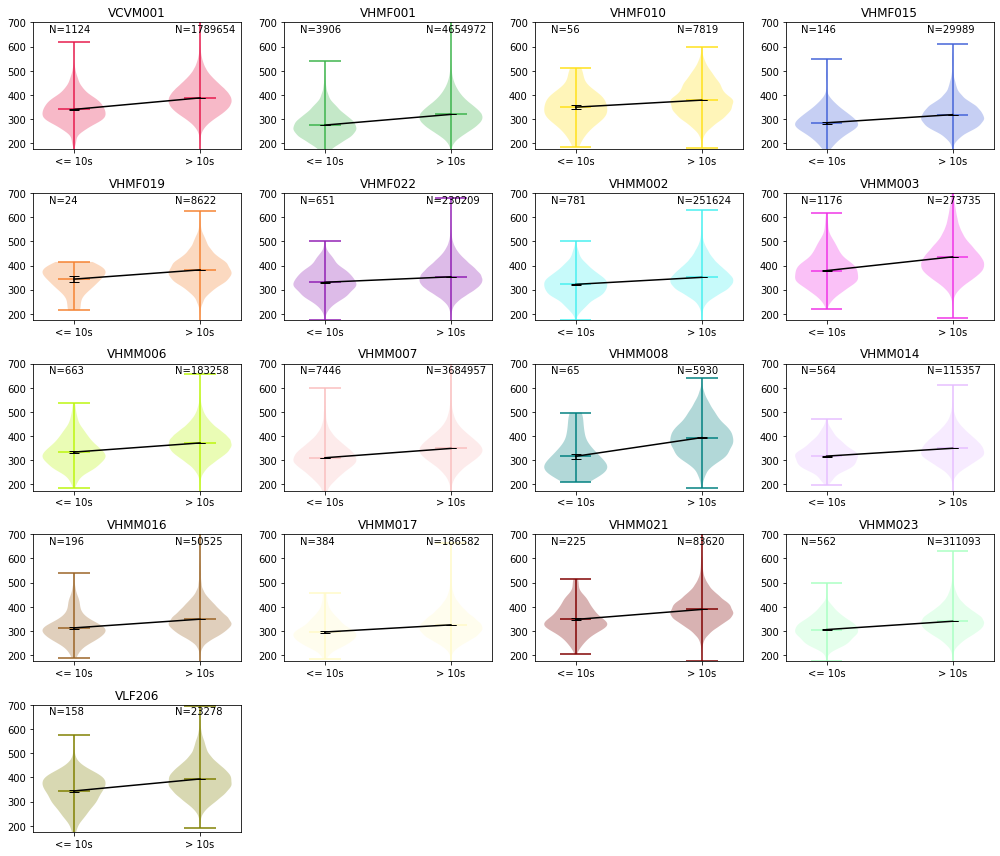

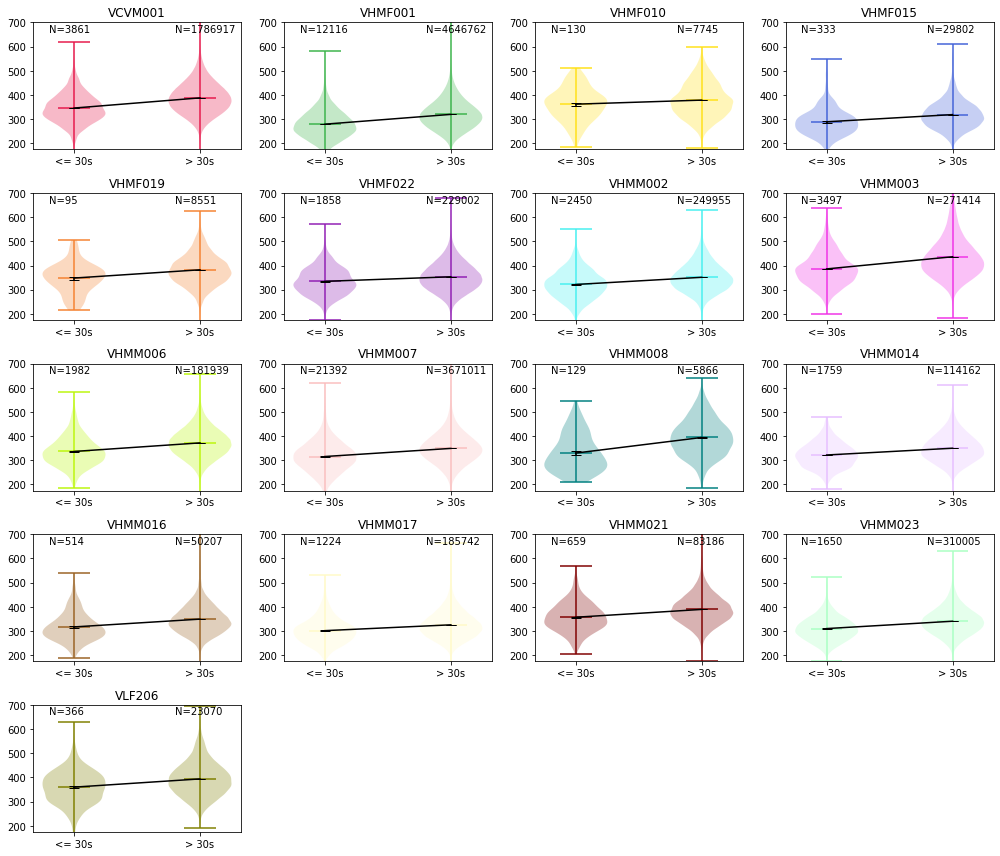

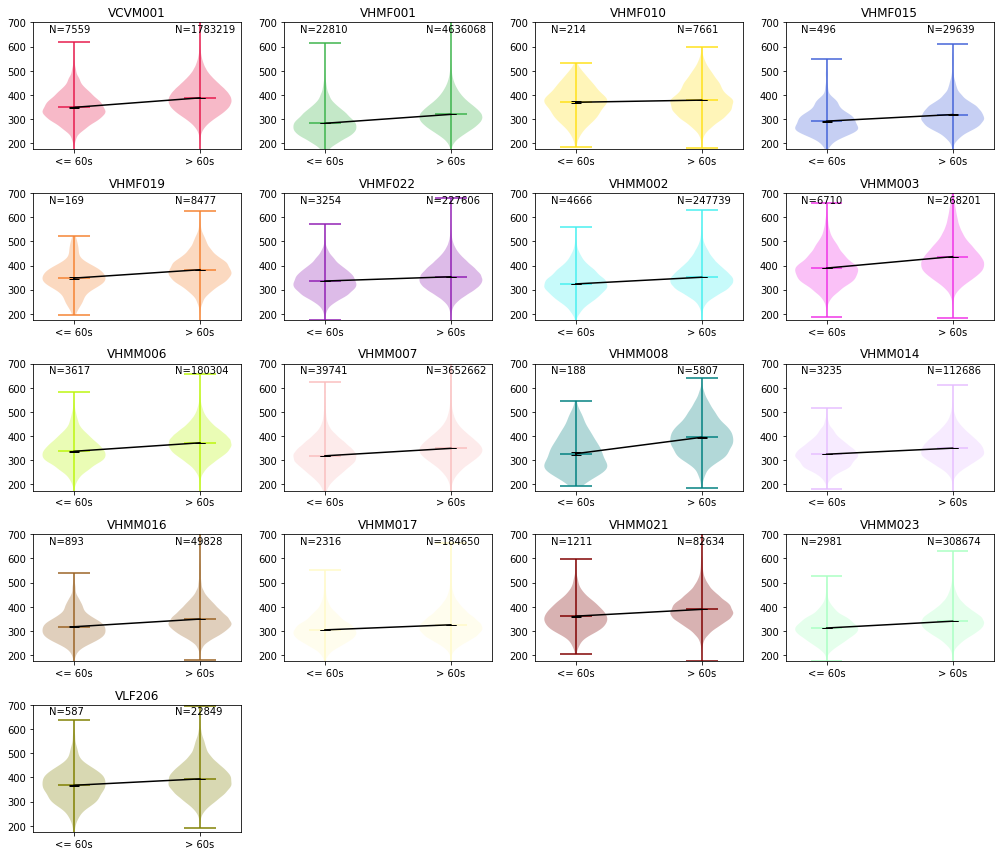

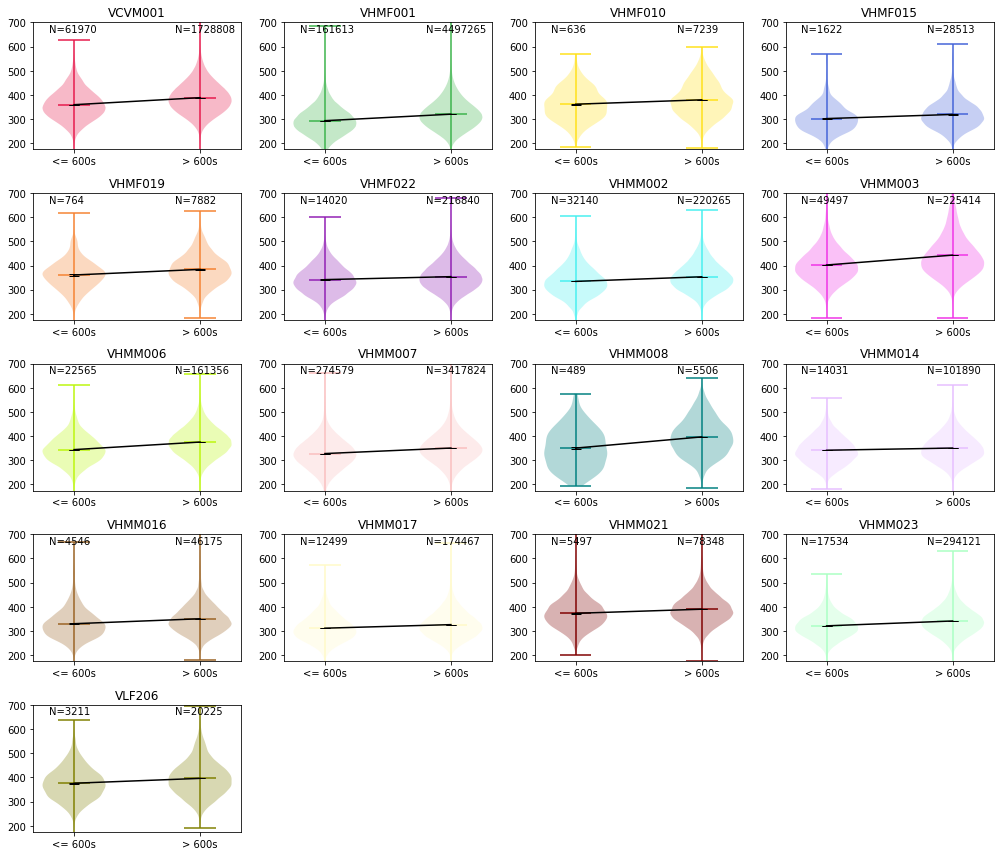

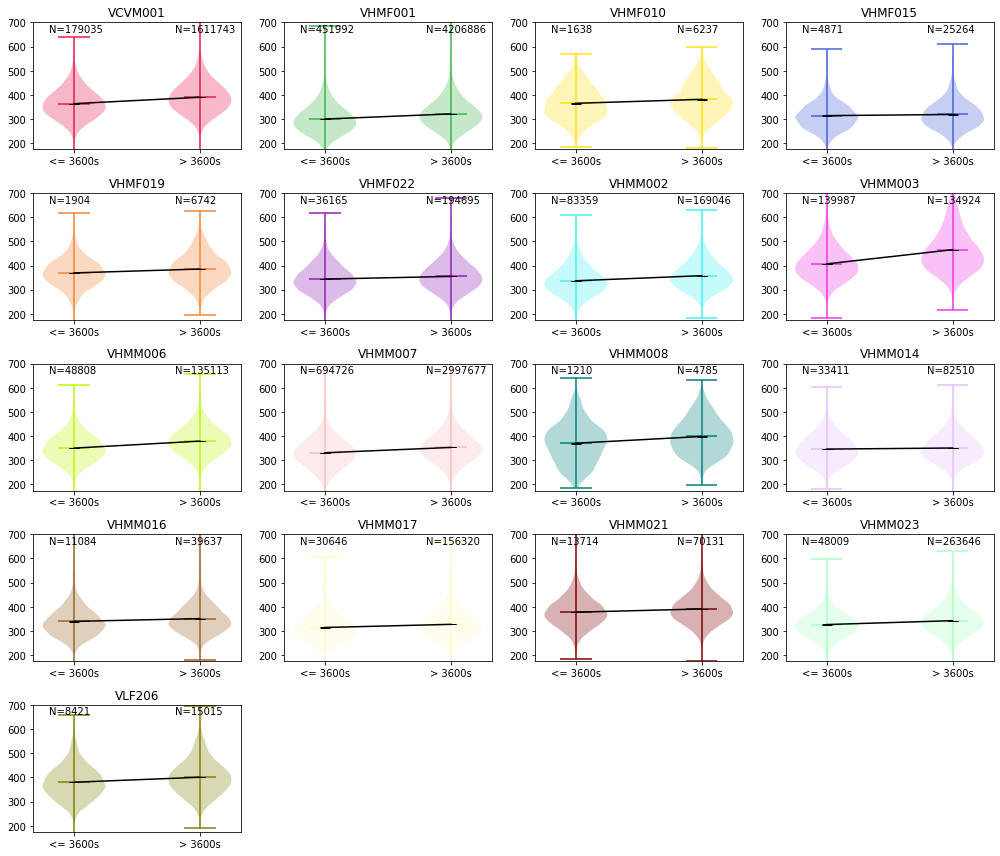

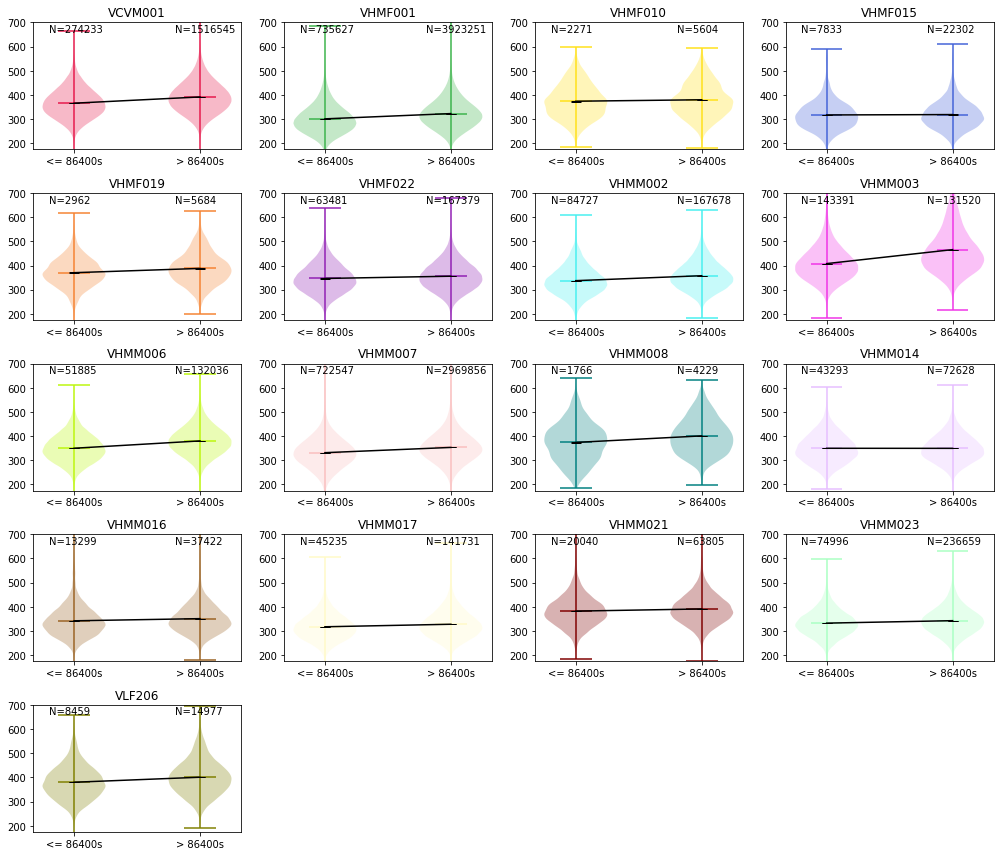

In [ ]:
for cutoff_s in [10,30,60,600,3600,3600*24]:
  
  fig = plt.figure(figsize=(14, 12))
  pos=1

  for ind in indvs:
    rns = [cc_df.index.get_loc(x) for x in cc_df.index[cc_df.ind==ind]]

    sub_distmat = distmat[rns,:]
    sub_distmat = sub_distmat[:,rns]

    sub_time_distmat = time_diff_mat[rns,:]
    sub_time_distmat = sub_time_distmat[:,rns]

    # Use only lower half of matrix, discard diagonal
    all_dists = []
    
    for i in range(sub_distmat.shape[0]):
      all_dists.append(sub_distmat[i,0:i])
    all_dists_vec = np.hstack(all_dists).flatten()

    # Use only lower half of matrix, discard original
    all_time_diffs = []

    for i in range(sub_time_distmat.shape[0]):
      all_time_diffs.append(sub_time_distmat[i,0:i])
    all_time_diffs_vec = np.hstack(all_time_diffs).flatten()

    bin_types = {
      0 : list(all_time_diffs_vec[all_time_diffs_vec<=cutoff_s]),
      1 : list(all_time_diffs_vec[all_time_diffs_vec>cutoff_s]),
      }
      
    # make dictionary labels to calls
    times_to_bins = dict((v,k) for k in bin_types for v in bin_types[k])

    x = [times_to_bins[x] for x in all_time_diffs_vec]
    
    plt.subplot(5, 4, pos)  

    within_dists = all_dists_vec[np.asarray(x)==0]
    outside_dists = all_dists_vec[np.asarray(x)==1]

    bp = plt.violinplot([within_dists, outside_dists],
                        showmeans=True)
        
    plt.text(0.8,660, "N="+str(len(within_dists)))
    plt.text(1.8,660, "N="+str(len(outside_dists)))

    for pc in bp['bodies']:
      pc.set_facecolor(color_dict[ind])

    for partname in ('cbars','cmins','cmaxes','cmeans'):
      vp = bp[partname]
      vp.set_edgecolor(color_dict[ind])

    plt.errorbar([1,2],
                [np.mean(within_dists), np.mean(outside_dists)], 
                yerr = [stats.sem(within_dists), stats.sem(outside_dists)],
                capsize=5, color = 'black')

    plt.xticks([1,2],['<= '+str(cutoff_s)+'s',
                      '> '+str(cutoff_s)+'s'])
    plt.title(ind)
    plt.ylim(175,700)
    pos = pos+1

  plt.tight_layout()
  plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'violin_all_ccs_'+str(cutoff_s)+'s.png')


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning

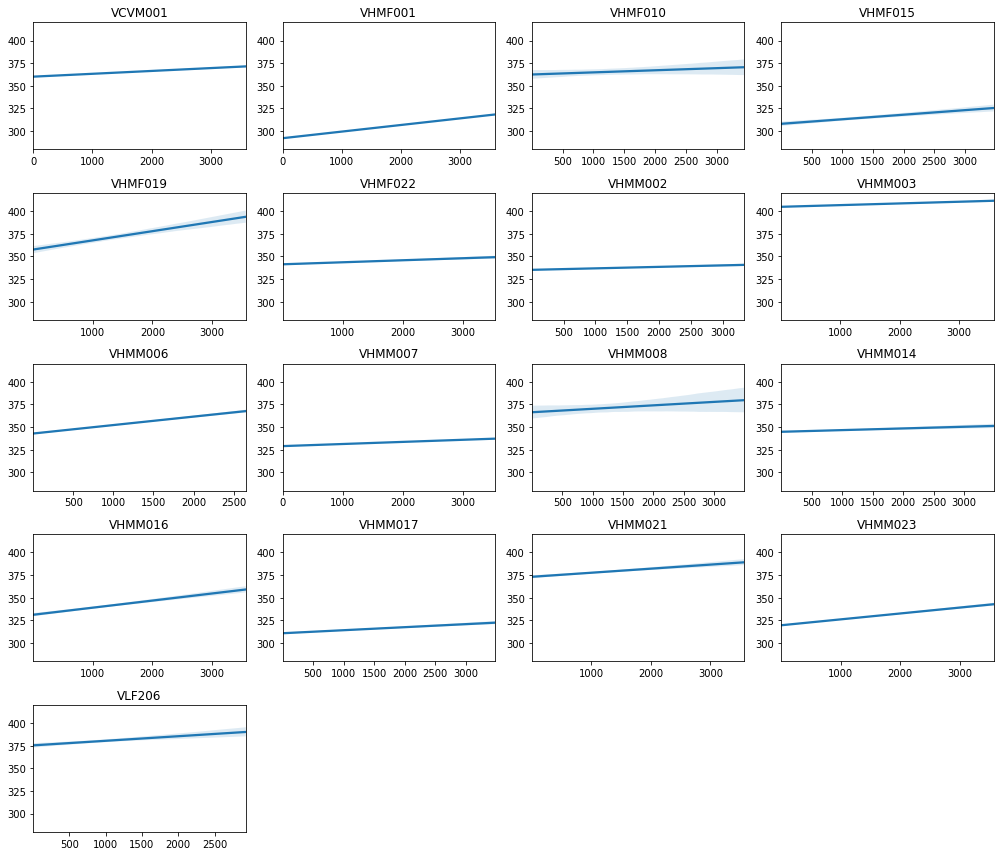

In [ ]:
import datetime

fig = plt.figure(figsize=(14, 12))
pos=1

for ind in indvs:
  rns = [cc_df.index.get_loc(x) for x in cc_df.index[cc_df.ind==ind]]

  sub_distmat = distmat[rns,:]
  sub_distmat = sub_distmat[:,rns]

  sub_time_distmat = time_diff_mat[rns,:]
  sub_time_distmat = sub_time_distmat[:,rns]

  # Use only lower half of matrix, discard diagonal
  all_dists = []
  
  for i in range(sub_distmat.shape[0]):
    all_dists.append(sub_distmat[i,0:i])
  all_dists_vec = np.hstack(all_dists).flatten()

  # Use only lower half of matrix, discard original
  all_time_diffs = []

  for i in range(sub_time_distmat.shape[0]):
    all_time_diffs.append(sub_time_distmat[i,0:i])
  all_time_diffs_vec = np.hstack(all_time_diffs).flatten()

  x = all_time_diffs_vec[all_time_diffs_vec<=60*60]
  y = all_dists_vec[all_time_diffs_vec<=60*60]

  #x = all_time_diffs_vec[all_time_diffs_vec<=60*10]
  #y = all_dists_vec[all_time_diffs_vec<=60*10]
  
  plt.subplot(5, 4, pos)  
  sns.regplot(x,y,scatter=False).set_title(ind)

  plt.title(ind)
  plt.ylim(280,420)
  pos = pos+1

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'reg_hour-axis.png')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



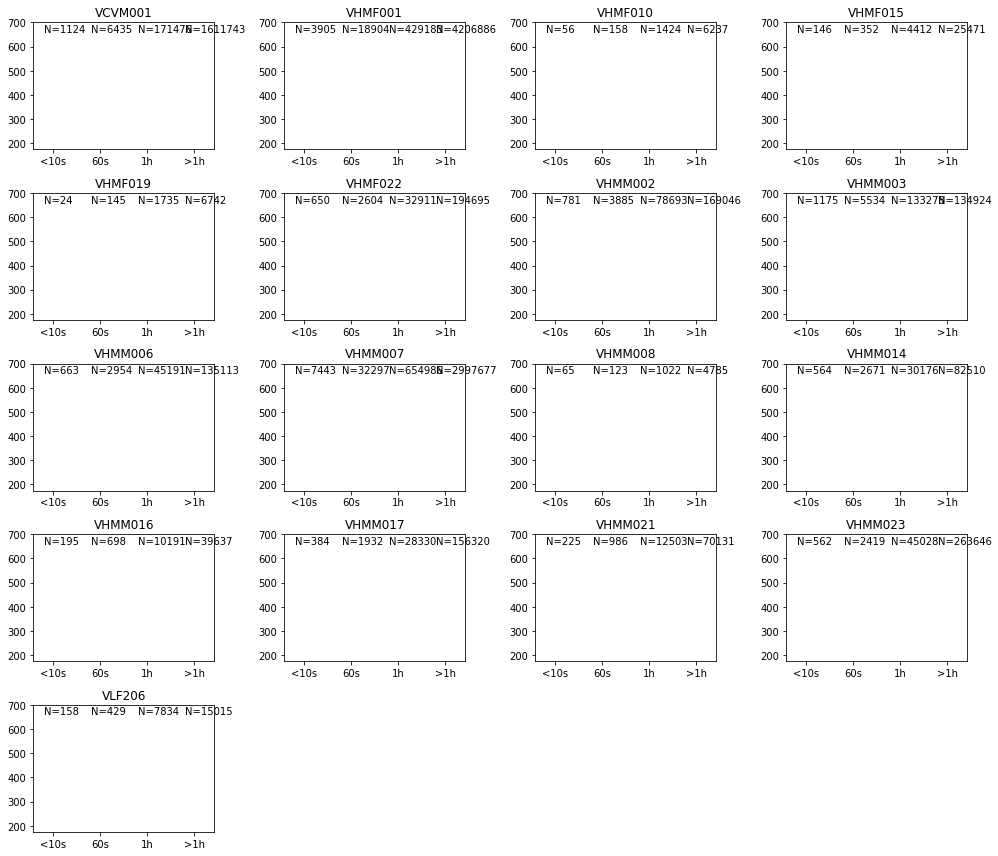

In [ ]:
import datetime

fig = plt.figure(figsize=(14, 12))
pos=1

for ind in indvs:
  rns = [cc_df.index.get_loc(x) for x in cc_df.index[cc_df.ind==ind]]

  sub_distmat = distmat[rns,:]
  sub_distmat = sub_distmat[:,rns]

  sub_time_distmat = time_diff_mat[rns,:]
  sub_time_distmat = sub_time_distmat[:,rns]

  # Use only lower half of matrix, discard diagonal
  all_dists = []
  
  for i in range(sub_distmat.shape[0]):
    all_dists.append(sub_distmat[i,0:i])
  all_dists_vec = np.hstack(all_dists).flatten()

  # Use only lower half of matrix, discard original
  all_time_diffs = []

  for i in range(sub_time_distmat.shape[0]):
    all_time_diffs.append(sub_time_distmat[i,0:i])
  all_time_diffs_vec = np.hstack(all_time_diffs).flatten()

  #x = all_time_diffs_vec[all_time_diffs_vec<=60*10]
  #y = all_dists_vec[all_time_diffs_vec<=60*10]

  bin_types = {
    0 : list(all_time_diffs_vec[all_time_diffs_vec<10]), # < 10s
    1 : list(all_time_diffs_vec[(all_time_diffs_vec>=10) & (all_time_diffs_vec<60)]), # same minute
    2 : list(all_time_diffs_vec[(all_time_diffs_vec>=60) & (all_time_diffs_vec<60*60)]), # same hour
    3 : list(all_time_diffs_vec[(all_time_diffs_vec>60*60)]), 
    }
    
  # make dictionary labels to calls
  times_to_bins = dict((v,k) for k in bin_types for v in bin_types[k])

  x = [times_to_bins[x] for x in all_time_diffs_vec]
  #y = all_dists_vec
  
  plt.subplot(5, 4, pos)  
  #sns.regplot(x,y,scatter=False).set_title(ind)


  data = [all_dists_vec[np.asarray(x)==0], all_dists_vec[np.asarray(x)==1], all_dists_vec[np.asarray(x)==2], all_dists_vec[np.asarray(x)==3]]

  bp = plt.violinplot(data,
                      showmeans=True)
  #widths = [(x.shape[0]/subset_df.shape[0]) for x in data])
  
  for d,dat in enumerate(data):
    plt.text(0.8+d,660, "N="+str(len(dat)))   

  for pc in bp['bodies']:
    pc.set_facecolor(color_dict[ind])

  for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = bp[partname]
    vp.set_edgecolor(color_dict[ind])

  plt.errorbar([1,2,3,4],
              [np.mean(dat) for dat in data], 
              yerr = [stats.sem(dat) for dat in data],
              capsize=5, color = 'black')

  plt.xticks([1,2,3,4],['<10s','60s', '1h', '>1h'])
  plt.title(ind)
  plt.ylim(175,700)
  pos = pos+1

plt.tight_layout()
plt.savefig(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_'+'violin_4_bins.png')